In [108]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [109]:
trainDF = pd.read_csv('train.csv')
testDF = pd.read_csv('test.csv')
concatDF = pd.concat([trainDF,testDF])
concatDF = concatDF.reset_index(drop=True)


print(concatDF.info())
concatDF.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB
None


,id,keyword,location,text,target
1447,2086,casualty,NaN,I still don't know why independence day and so...,0.0


In [110]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF:pd.DataFrame):
        if 'target' in DF.columns:
            self.target= DF['target'].values
        else:
            self.target= DF['id'].values
        self.text = DF['text'].values
        self.id= DF['id'].values
        self.keyword= DF['keyword'].values
        self.location= DF['location'].values
        pass

    def __len__(self):
        return len(self.id)

    def __getitem__(self, idx):
        text = self.text[idx]
        target = self.target[idx]
        keyword = self.keyword[idx]
        location = self.location[idx]

        return target, text, keyword, location


trainSet= MyDataset(DF=trainDF)
testSet= MyDataset(DF=testDF)
trainSet[0]

(1,
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 nan,
 nan)

In [111]:
myTokenizer = get_tokenizer('basic_english')
token = myTokenizer('0 wolrd')
token

['0', 'wolrd']

In [112]:
def yield_tokens(myIter):
    for  _ , text, _, _ in myIter:
        yield  myTokenizer(text)

def yield_keyword(myIter):
    for  _ , _, keyword, _ in myIter:
        yield  myTokenizer(str(keyword))

def yield_loc(myIter):
    for  _ , _, _ , loc in myIter:
        yield  myTokenizer(str(loc))


vocab = build_vocab_from_iterator(yield_tokens(iter(trainSet)), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

keywordVocab = build_vocab_from_iterator(yield_keyword(iter(trainSet)), specials=['<unk>'])
keywordVocab.set_default_index(vocab['<unk>'])

locVocab = build_vocab_from_iterator(yield_loc(iter(trainSet)), specials=['<unk>'])
locVocab.set_default_index(vocab['<unk>'])

vocab(['Our', 'Deeds', 'are', 'the', 'Reason', 'of'])
keywordVocab(['apocalypse'])
locVocab(['arizona'])

[198]

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [114]:
trainSet, valSet = torch.utils.data.dataset.random_split(
    dataset=trainSet,lengths=[0.8,0.2]
)
trainSet[0]

(0,
 "k_matako_bot: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.",
 'loud%20bang',
 'Kenya')

In [115]:
def myCollate(batch):
    labelList = []
    textList=[]
    offset=[0]
    keyOffset=[0]
    keywordList=[]

    locList=[]
    locOff=[0]
    for label, text, keyword, loc in batch:
        labelList.append(label)

        text = vocab(myTokenizer(text))
        text = torch.tensor(text)
        textList.append(text)

        offset.append(text.size(0))

        keyword= keywordVocab(myTokenizer(str(keyword)))
        keyword = torch.tensor(keyword)
        keywordList.append(keyword)

        keyOffset.append(keyword.size(0))

        loc= locVocab(myTokenizer(str(loc)))
        loc = torch.tensor(loc).to(torch.int64)
        locList.append(loc)

        locOff.append(loc.size(0))


    labelList = torch.tensor(labelList)

    textList= torch.cat(textList)

    offset = offset[:-1]
    offset = torch.tensor(offset)
    offset = offset.cumsum(dim=0)
    keywordList= torch.cat(keywordList)

    keyOffset = keyOffset[:-1]
    keyOffset = torch.tensor(keyOffset)
    keyOffset = keyOffset.cumsum(dim=0)

    locList= torch.cat(locList)

    locOff= locOff[:-1]
    locOff= torch.tensor(locOff)
    locOff= locOff.cumsum(dim=0)

    return labelList.to(device), textList.to(device), offset.to(device), keywordList.to(device), keyOffset.to(device), locList.to(device), locOff.to(device)

trainLoader = torch.utils.data.DataLoader(dataset=trainSet,batch_size=10,sampler=torch.utils.data.RandomSampler(trainSet), collate_fn=myCollate)
valLoader = torch.utils.data.DataLoader(dataset=valSet,collate_fn=myCollate)
testLoader = torch.utils.data.DataLoader(dataset=testSet,collate_fn=myCollate)
next(iter(trainLoader))

(tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 0]),
 tensor([  173,  6189,  2429,  1222,  1696,    16,  1989,  1589, 17404,    35,
          5500,    34,     3,     2,     1, 15087,   215,  1446, 11956,   669,
            48,    10,   515,     8,  2123,     3,     2,     1, 12688,    65,
          9584,     4,   214,    66,   206,   534,    25,   196,    99,   200,
            19,   750,    97,     3,     2,     1, 15749,  3105,     4,   127,
            10,  1482,  2190,   690,   278,  1327,    40,    12,    78,     4,
          4548,   588,     3,     2,     1, 13661,   140,     9,   638,    76,
           207,    66,    86,   414,   140,   494,    25,     4,   192,   337,
            10,  6041,     1,     1,     1,     3,     2,     1, 16146,  7826,
         10910, 10659,    11,    33,  3842,   388,    66, 21366,    86, 22536,
             1,  2451,   388,     1, 18294,  1595,     1,  7084,    20,    42,
          6945,    73,   115,    71,    89,    84,  1817,     8,  4139,    33,
           

In [116]:
class myModel(torch.nn.Module):
    def __init__(self, vocabSize,keyVocabSize,locVocabSize, embeddingDim, classCnt) -> None:
        super().__init__()
        self.embadding_text=torch.nn.EmbeddingBag(vocabSize, embeddingDim)
        self.embadding_keyword=torch.nn.EmbeddingBag(keyVocabSize, embeddingDim)
        self.embadding_location=torch.nn.EmbeddingBag(locVocabSize, embeddingDim)
        self.linear1 = torch.nn.Linear(embeddingDim*3, embeddingDim*3)
        self.linear2 = torch.nn.Linear(embeddingDim*3, classCnt)

    def forward(self,text, offset, keyword, keyOffset,loc,locOff ):
        logits_text = self.embadding_text(text,offset)
        logits_keyword = self.embadding_keyword(keyword,keyOffset)
        logits_location= self.embadding_location(loc,locOff)

        logits = torch.nn.functional.relu(self.linear1(torch.cat((logits_text,logits_keyword, logits_location),1)))
        logits = self.linear2(logits)

        return logits

model = myModel(len(vocab),len(keywordVocab),len(locVocab),3,2).to(device)

label, text, offset, keyword, keyOffset, loc, locOff= next(iter(trainLoader))
model(text, offset, keyword, keyOffset, loc, locOff )

tensor([[-0.0502,  0.1158],
        [-0.0503,  0.0277],
        [ 0.2464, -0.0964],
        [-0.2825,  0.5752],
        [ 0.0126, -0.0742],
        [-0.2595,  0.3027],
        [ 0.0330,  0.1048],
        [-0.0853,  0.4807],
        [-0.0043,  0.0569],
        [-0.2520,  0.0728]], grad_fn=<AddmmBackward0>)

-1 0.5565045992115637 1046.5444037914276 420.7571897506714
0 0.561760840998686 1038.1402215063572 413.653145134449
0 0.5650459921156373 1036.3717660605907 412.11377650499344
0 0.5860709592641261 1030.1368321478367 410.54524797201157
0 0.573587385019711 1029.087758421898 409.5275990366936
0 0.5755584756898817 1028.0276063978672 408.7990364432335
0 0.5873850197109067 1024.0839621424675 407.89877289533615
0 0.5873850197109067 1022.2085243314505 407.04806727170944
0 0.5867279894875165 1020.3100889027119 406.1062039732933
0 0.6018396846254928 1014.7261211276054 405.13246750831604
0 0.5965834428383706 1016.975382104516 403.8968700170517
1 0.6038107752956636 1014.3456223160028 403.6388645172119
0 0.614323258869908 1007.1037532687187 402.87423864006996
0 0.6123521681997371 1008.1681771352887 401.73827117681503
1 0.6130091984231275 1010.4336045607924 401.4091031551361
2 0.6195795006570303 1001.550440788269 400.2796981334686
0 0.6123521681997371 1005.0808760225773 399.8710583150387
1 0.609724047

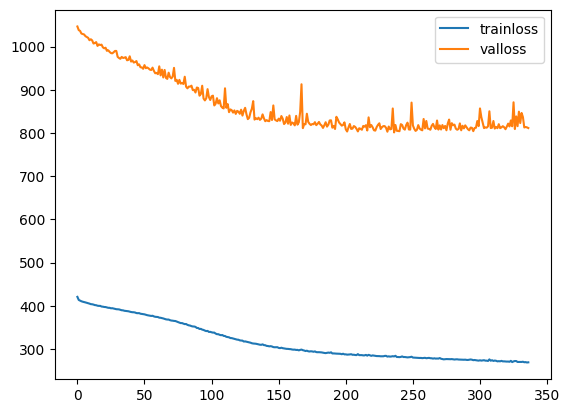

In [117]:
lossFunc = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.01)
lrScheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)

def train(dataLoader,model, lossFunc, optim):
    model.train()
    trainLoss = 0
    for label, text, offset, key, keyOff,loc, locOff in dataLoader:

        logits = model(text, offset, key, keyOff, loc, locOff )
        loss = lossFunc(logits, label)

        trainLoss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()

    return trainLoss

def val(dataLoader,model, lossFunc):
    model.eval()
    valLoss = 0
    accuracy = 0
    with torch.no_grad():
        for label, text, offset,key,keyOff,loc,locOff in dataLoader:
            logits = model(text, offset,key, keyOff,loc,locOff)
            loss = lossFunc(logits, label)

            accuracy += (logits.argmax(1) == label).sum().item()
            valLoss += loss.item()

    return valLoss, accuracy/len(dataLoader)

bestLoss = float('inf')
trainlossList=[]
vallossList=[]
bestModel=model
cnt=-1

while(cnt<100):
    trainLoss = train(trainLoader,model, lossFunc, optim)
    valLoss, accuracy= val(valLoader,model, lossFunc)
    trainlossList.append(trainLoss)
    vallossList.append(valLoss)
    print(f'{cnt} {accuracy} {valLoss} {trainLoss}')

    if valLoss >bestLoss:
        # lrScheduler.step()
        cnt+=1
    else:
        bestLoss = valLoss
        bestModel = model
        cnt = 0 

plt.plot(trainlossList, label='trainloss')
plt.plot(vallossList, label='valloss')
plt.legend()

In [118]:
plt.close()

In [119]:
def test(dataLoader,model):
    model.eval()
    result = []

    with torch.no_grad():
        for id, text, offset, key , keyOff, loc, locOff in dataLoader:
            logits = model(text, offset, key, keyOff, loc, locOff)
            result.append([id.item(), logits.argmax().item()])


    return  result

result = test(testLoader, bestModel)
resultDF = pd.DataFrame(result).rename(columns={0:'id',1:'target'})
resultDF

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [120]:
resultDF.to_csv('sample_submission.csv', index=False)